In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from glob import glob
import scipy.io
import torch.nn as nn
import torch
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [ ]:
# Load EEG signal dataset
def load_dataset():
    data_array = np.load('/content/drive/MyDrive/Colab Notebooks/data_array.npy')
    label_array = np.load('/content/drive/MyDrive/Colab Notebooks/label_array.npy')
    group_array = np.load('/content/drive/MyDrive/Colab Notebooks/group_array.npy')


    return data_array,label_array,group_array


# Define the RNN model
def create_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(128, input_shape=input_shape, return_sequences=True))  # RNN layer with 128 units and return sequences
    model.add(SimpleRNN(128))  # Additional RNN layer with 128 units
    model.add(Dense(64, activation='relu'))  # Dense layer with 64 units and ReLU activation
    model.add(Dense(1, activation='sigmoid'))  # Output layer with sigmoid activation

    return model

In [ ]:
# Load the dataset
data_array,label_array,group_array = load_dataset()
print(data_array.shape,label_array.shape,group_array.shape)

(7150, 1250, 33) (7150,) (7150,)


In [ ]:
# convert the problem from multiclass classification to binary classification
# make haemorrhage and schaemia classes as one
label_array = label_array.astype('int')
label_array[label_array==0] = 1 #Stroke
label_array[label_array==2] = 0 #Healthy


In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_array, label_array, test_size=0.2, random_state=42)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Print the shapes of the resulting arrays
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)


(4576, 1250, 33) (4576,)
(1144, 1250, 33) (1144,)
(1430, 1250, 33) (1430,)


In [ ]:
# prompt: print the split percentages for train, val, test

print("Train size:", len(X_train) / len(data_array) * 100, "%")
print("Validation size:", len(X_val) / len(data_array) * 100, "%")
print("Test size:", len(X_test) / len(data_array) * 100, "%")

Train size: 64.0 %
Validation size: 16.0 %
Test size: 20.0 %


In [ ]:
print((y_train == 0).sum())
print((y_test == 0).sum())
print((y_val == 0).sum())

1782
557
457


In [ ]:
print((y_train == 1).sum())
print((y_test == 1).sum())
print((y_val == 1).sum())

2794
873
687


In [ ]:
# Create the RNN model
input_shape = X_train.shape[1:]
model = create_model(input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 1250, 128)         20736     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61953 (242.00 KB)
Trainable params: 61953 (242.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
# Specify the Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# Train the model
history=model.fit(X_train, y_train, epochs=100, batch_size=132, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
35/35 [==============================] - 140s 4s/step - loss: 0.6966 - accuracy: 0.5411 - val_loss: 0.6882 - val_accuracy: 0.5446
Epoch 2/100
35/35 [==============================] - 129s 4s/step - loss: 0.6560 - accuracy: 0.6066 - val_loss: 0.6726 - val_accuracy: 0.5752
Epoch 3/100
35/35 [==============================] - 128s 4s/step - loss: 0.6291 - accuracy: 0.6538 - val_loss: 0.6606 - val_accuracy: 0.6040
Epoch 4/100
35/35 [==============================] - 127s 4s/step - loss: 0.6058 - accuracy: 0.6844 - val_loss: 0.6476 - val_accuracy: 0.6128
Epoch 5/100
35/35 [==============================] - 127s 4s/step - loss: 0.5814 - accuracy: 0.7118 - val_loss: 0.6336 - val_accuracy: 0.6233
Epoch 6/100
35/35 [==============================] - 127s 4s/step - loss: 0.5576 - accuracy: 0.7306 - val_loss: 0.6194 - val_accuracy: 0.6364
Epoch 7/100
35/35 [==============================] - 129s 4s/step - loss: 0.5334 - accuracy: 0.7524 - val_loss: 0.6064 - val_accuracy: 0.6503
Epoch 

In [ ]:
# Predict on test data
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate the evaluation metrics
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
f1_metric = f1_score(y_test, y_pred_binary)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1_metric)

45/45 [==============================] - 21s 453ms/step
Accuracy: 0.7475524475524475
Precision: 0.7644628099173554
Recall: 0.847651775486827
F1-score: 0.803910917979359


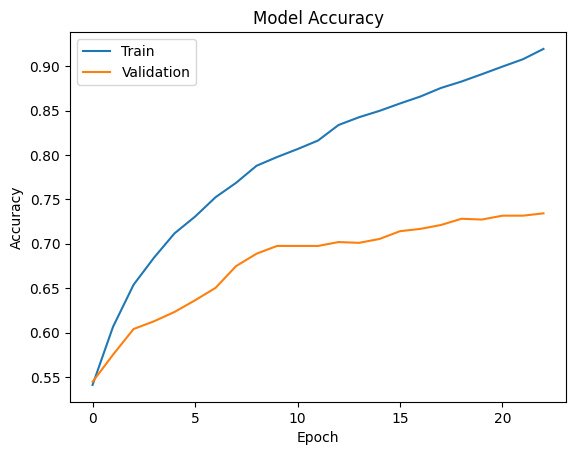

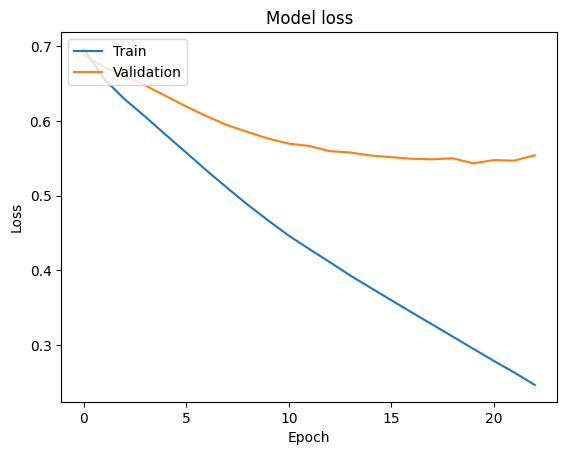

In [ ]:
# plot model accuracy and loss of training and validation

import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Average Confusion Matrix:
45/45 [==============================] - 10s 216ms/step


<Figure size 800x600 with 0 Axes>

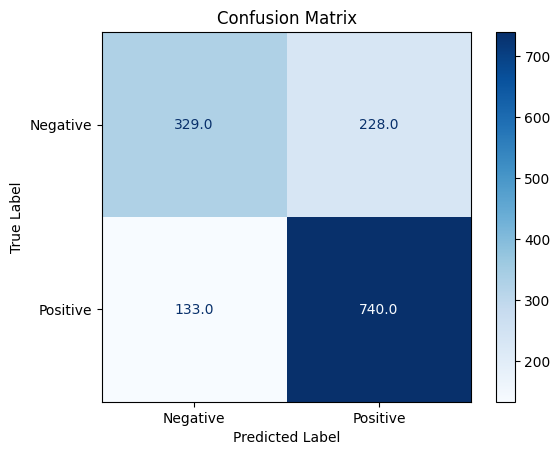

              precision    recall  f1-score   support

           0       0.71      0.59      0.65       557
           1       0.76      0.85      0.80       873

    accuracy                           0.75      1430
   macro avg       0.74      0.72      0.72      1430
weighted avg       0.74      0.75      0.74      1430



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

print("Average Confusion Matrix:")

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

# Print or use the results as needed
# Calculate confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm_display.plot(cmap='Blues', values_format='.1f')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

from sklearn.metrics import classification_report
# Generate classification report
report = classification_report(y_test.ravel(), y_pred.ravel())

# Print the report
print(report)


In [ ]:
model.save("RNN_model_f1.h5")

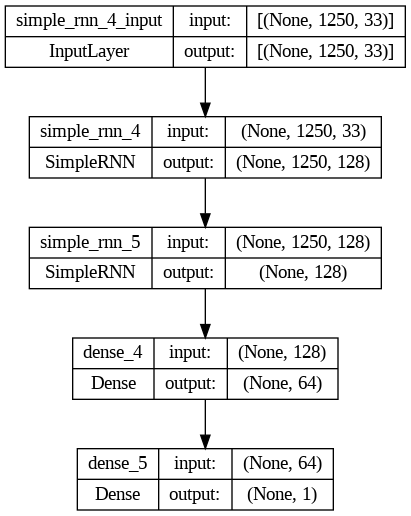

In [ ]:
loaded_model = tf.keras.models.load_model('/content/RNN_model_f1.h5')
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
plot_model(loaded_model, to_file='/content/drive/MyDrive/Colab Notebooks/RNN.png', show_shapes=True)